In [1]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [6]:
from sklearn.datasets import load_digits # MNIST 손글씨 데이터셋을 사용하기 위해 import 한다.
from sklearn.neighbors import KNeighborsClassifier # kNN
from sklearn.svm import SVC # SVM
from sklearn import tree # 의사결정 트리
# 하드/소프트 보팅을 계산하기 위해 import 한다.
from sklearn.ensemble import VotingClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

손글씨 데이터를 불러온다.

In [7]:
mnist = load_digits()
features, labels = mnist.data, mnist.target
print(features.shape, labels.shape)

(1797, 64) (1797,)


학습 데이터와 테스트 데이터를 나눈다.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
print('학습 데이터 개수: {}, 테스트 데이터 개수: {}'.format(X_train.shape[0], X_test.shape[0]))

학습 데이터 개수: 1437, 테스트 데이터 개수: 360


단일 모델이 정확도 측정  
앙상블 정확도를 측정하기에 앞서서 단일 모델들의 정확도를 kNN, SVC, 의사결정 트리 분류기를 만들어 정확도를 계산한다.

In [18]:
# kNN
knn = KNeighborsClassifier(n_neighbors=299).fit(X_train, y_train)
knn_predict = knn.predict(X_test)
print('knn accuracy 정확도: {:6.2%}'.format(accuracy_score(y_test, knn_predict)))

knn accuracy 정확도: 83.33%


In [22]:
# SVM
svm = SVC(C=0.1, gamma=0.003, probability=True, random_state=35).fit(X_train, y_train)
svm_predict = svm.predict(X_test)
print('svm accuracy 정확도: {:6.2%}'.format(accuracy_score(y_test, svm_predict)))

svm accuracy 정확도: 91.39%


In [24]:
# 의사결정 트리
dtree = tree.DecisionTreeClassifier(max_depth=8, random_state=35).fit(X_train, y_train)
dtree_predict = dtree.predict(X_test)
print('dtree accuracy 정확도: {:6.2%}'.format(accuracy_score(y_test, dtree_predict)))

dtree accuracy 정확도: 81.67%


하드 보팅, 소프트 보팅은 VotingClassifier를 사용해 쉽게 구현할 수 있다.

하드 보팅  
일반적인 투표와 같이 각 분류기의 예측값들을 모아 가장 많은 투표를 받은 예측값으로 최종 결론을 내린다.

In [26]:
hv_clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('decision_tree', dtree)], weights=[1, 1, 1],
                voting='hard').fit(X_train, y_train)
hv_predict = hv_clf.predict(X_test)
print('hard_voting: {:%}'.format(accuracy_score(y_test, hv_predict)))

hard_voting: 90.833333%


소프트 보팅  
각 분류값별 확률을 더해준 값을 점수로 사용해 최대 점수를 가진 분류값으로 결론을 내린다.

확률 합계

In [31]:
# predict_proba() 메소드로 분류 모델이 각 클래스(타겟, 레이블, 실제값)의 확률을 계산한다.
knn_proba = knn.predict_proba(X_test)
#print(knn_proba)
print(knn_proba[0])
print('확률 합계: {}'.format(knn_proba[0].sum()))

[0.04347826 0.04682274 0.07692308 0.13043478 0.         0.02341137
 0.25752508 0.         0.27759197 0.14381271]
확률 합계: 1.0


In [32]:
svm_proba = svm.predict_proba(X_test)
print(svm_proba[0])
print('확률 합계: {}'.format(svm_proba[0].sum()))

[0.00829485 0.04846673 0.04140506 0.02538155 0.01922868 0.02542684
 0.01990068 0.02339998 0.70198949 0.08650614]
확률 합계: 0.9999999999999999


In [33]:
dtree_proba = dtree.predict_proba(X_test)
print(dtree_proba[0])
print('확률 합계: {}'.format(dtree_proba[0].sum()))

[0.00952381 0.02857143 0.00952381 0.00952381 0.         0.00952381
 0.         0.01904762 0.85714286 0.05714286]
확률 합계: 1.0


In [34]:
sv_clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('decision_tree', dtree)], weights=[1, 1, 1],
                voting='soft').fit(X_train, y_train)
sv_predict = sv_clf.predict(X_test)
print('soft_voting: {:%}'.format(accuracy_score(y_test, sv_predict)))

soft_voting: 89.166667%


단일 모델과 앙상블 모델의 정확도 비교 시각화

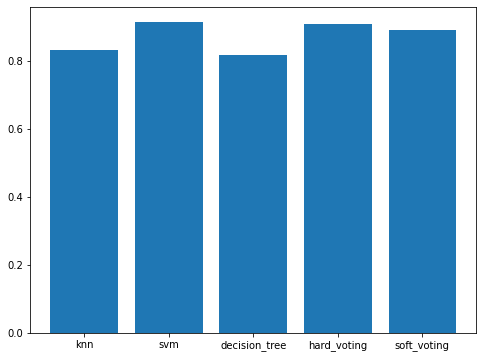

In [35]:
plt.figure(figsize=(8, 6))
x = np.arange(5)
plt.bar(x, height=[
    accuracy_score(y_test, knn_predict),
    accuracy_score(y_test, svm_predict),
    accuracy_score(y_test, dtree_predict),
    accuracy_score(y_test, hv_predict),
    accuracy_score(y_test, sv_predict)
])
plt.xticks(x, ['knn', 'svm', 'decision_tree', 'hard_voting', 'soft_voting'])
plt.show()